In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from google.colab import files

# Create a project folder in Drive
PROJECT_DIR = '/content/drive/MyDrive/credit_fraud_scarf'
os.makedirs(PROJECT_DIR, exist_ok=True)


Mounted at /content/drive


In [ ]:
# Upload dataset from local machine
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [ ]:
# Move uploaded file to project folder
import shutil
for fname in uploaded.keys():
    shutil.move(fname, os.path.join(PROJECT_DIR, fname))

print(f"✅ Dataset saved to: {PROJECT_DIR}")

✅ Dataset saved to: /content/drive/MyDrive/credit_fraud_scarf


In [ ]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 19.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import hashlib
import mlflow
import os

# ==============================
# CONFIG
# ==============================
DATA_PATH = os.path.join(PROJECT_DIR, "creditcard.csv")  # From Cell 1
ARTIFACT_DIR = os.path.join(PROJECT_DIR, "artifacts", "preprocessing")
os.makedirs(ARTIFACT_DIR, exist_ok=True)

TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15  # Remaining 15% is test
SCALE_FEATURES = ["Time", "Amount"]

# ==============================
# UTILS
# ==============================
def hash_df(df):
    """Generate reproducibility hash for a DataFrame."""
    return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

# ==============================
# MLOPS: Set MLflow Tracking to Drive
# ==============================
MLFLOW_DIR = os.path.join(PROJECT_DIR, "mlruns")
mlflow.set_tracking_uri(f"file://{MLFLOW_DIR}")
mlflow.set_experiment("CreditCardFraud_SCARF")

with mlflow.start_run(run_name="preprocessing"):

    # ------------------------------
    # 1. Load & Sort
    # ------------------------------
    df = pd.read_csv(DATA_PATH)
    df = df.sort_values("Time").reset_index(drop=True)

    # ------------------------------
    # 2. Separate normal & fraud
    # ------------------------------
    df_normal = df[df["Class"] == 0]
    df_fraud = df[df["Class"] == 1]

    # ------------------------------
    # 3. Time-aware split
    # ------------------------------
    n_normal = len(df_normal)
    train_end = int(TRAIN_SPLIT * n_normal)
    val_end = int((TRAIN_SPLIT + VAL_SPLIT) * n_normal)

    train_normal = df_normal.iloc[:train_end].copy()
    val_normal = df_normal.iloc[train_end:val_end].copy()
    test_normal = df_normal.iloc[val_end:].copy()

    # ------------------------------
    # 4. Build Test_mixed
    # ------------------------------
    test_mixed = pd.concat([test_normal, df_fraud], axis=0)
    test_mixed = test_mixed.sort_values("Time").reset_index(drop=True)

    # ------------------------------
    # 5. Scaling
    # ------------------------------
    scaler = StandardScaler()
    train_normal[SCALE_FEATURES] = scaler.fit_transform(train_normal[SCALE_FEATURES])
    val_normal[SCALE_FEATURES] = scaler.transform(val_normal[SCALE_FEATURES])
    test_mixed[SCALE_FEATURES] = scaler.transform(test_mixed[SCALE_FEATURES])

    # ------------------------------
    # 6. Save artifacts to Drive
    # ------------------------------
    train_path = os.path.join(ARTIFACT_DIR, "Train_normal.csv")
    val_path = os.path.join(ARTIFACT_DIR, "Val_normal.csv")
    test_path = os.path.join(ARTIFACT_DIR, "Test_mixed.csv")
    scaler_path = os.path.join(ARTIFACT_DIR, "scaler.pkl")
    hash_path = os.path.join(ARTIFACT_DIR, "split_hashes.txt")

    train_normal.to_csv(train_path, index=False)
    val_normal.to_csv(val_path, index=False)
    test_mixed.to_csv(test_path, index=False)
    joblib.dump(scaler, scaler_path)

    hashes = {
        "train_hash": hash_df(train_normal),
        "val_hash": hash_df(val_normal),
        "test_hash": hash_df(test_mixed)
    }
    with open(hash_path, "w") as f:
        for k, v in hashes.items():
            f.write(f"{k}: {v}\n")

    # ------------------------------
    # 7. MLflow Logging
    # ------------------------------
    mlflow.log_params({
        "train_size": len(train_normal),
        "val_size": len(val_normal),
        "test_size": len(test_mixed),
        "train_split_ratio": TRAIN_SPLIT,
        "val_split_ratio": VAL_SPLIT,
        "scale_features": SCALE_FEATURES
    })

    mlflow.log_metrics({
        "fraud_cases_test": int((test_mixed["Class"] == 1).sum()),
        "fraud_cases_train": int((train_normal["Class"] == 1).sum())
    })

    mlflow.log_artifact(train_path)
    mlflow.log_artifact(val_path)
    mlflow.log_artifact(test_path)
    mlflow.log_artifact(scaler_path)
    mlflow.log_artifact(hash_path)

    print("✅ Preprocessing complete. All artifacts & MLflow logs saved to Drive.")

2025/08/11 14:37:44 INFO mlflow.tracking.fluent: Experiment with name 'CreditCardFraud_SCARF' does not exist. Creating a new experiment.


✅ Preprocessing complete. All artifacts & MLflow logs saved to Drive.


SCRAF Representation

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Path to your project folder in Google Drive
PROJECT_DIR = '/content/drive/MyDrive/credit_fraud_scarf'

# Paths for MLflow tracking
MLFLOW_DIR = os.path.join(PROJECT_DIR, "mlruns")

Mounted at /content/drive


In [ ]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 17.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os

# Paths to saved artifacts
train_path = os.path.join(PROJECT_DIR, "artifacts/preprocessing/Train_normal.csv")
val_path   = os.path.join(PROJECT_DIR, "artifacts/preprocessing/Val_normal.csv")
test_path  = os.path.join(PROJECT_DIR, "artifacts/preprocessing/Test_mixed.csv")

# Load datasets
train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)
test_df  = pd.read_csv(test_path)

print("✅ Data loaded from Drive")
print(f"Train_normal: {train_df.shape} | Val_normal: {val_df.shape} | Test_mixed: {test_df.shape}")

✅ Data loaded from Drive
Train_normal: (199020, 31) | Val_normal: (42647, 31) | Test_mixed: (43140, 31)


In [ ]:
import torch
import torch.nn as nn

class MaskingAugmentation(nn.Module):
    def __init__(self, num_features, mask_prob=0.15):
        super().__init__()
        self.mask_prob = mask_prob
        self.mask_token = nn.Parameter(torch.zeros(num_features))  # Learnable token per feature

    def forward(self, X):
        device = X.device
        mask = torch.rand_like(X) < self.mask_prob
        X_masked = X.clone()
        feature_idx = mask.nonzero(as_tuple=True)[1]
        X_masked[mask] = self.mask_token.to(device)[feature_idx]  # Ensure same device
        return X_masked

In [ ]:
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, output_dim=128):
        super().__init__()
        layers = []
        dim_in = input_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(dim_in, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            dim_in = hidden_dim
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class SCARF(nn.Module):
    def __init__(self, encoder, projection_dim=64):
        super().__init__()
        self.encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(encoder.net[-1].out_features, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x1, x2):
        z1 = self.projector(self.encoder(x1))
        z2 = self.projector(self.encoder(x2))
        return z1, z2

In [ ]:
import torch.nn.functional as F

# InfoNCE
def info_nce_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = torch.matmul(representations, representations.T)
    batch_size = z1.size(0)
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z1.device)
    positives = torch.cat([torch.diag(similarity_matrix, batch_size),
                            torch.diag(similarity_matrix, -batch_size)], dim=0)
    negatives = similarity_matrix[~mask].view(2 * batch_size, -1)
    logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
    labels = torch.zeros(2 * batch_size, dtype=torch.long).to(z1.device)
    logits = logits / temperature
    loss = F.cross_entropy(logits, labels)
    return loss

# Barlow Twins
def barlow_twins_loss(z1, z2, lambda_bt=5e-3):
    z1 = (z1 - z1.mean(0)) / z1.std(0)
    z2 = (z2 - z2.mean(0)) / z2.std(0)
    N, D = z1.size()
    c = torch.mm(z1.T, z2) / N
    on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
    off_diag = off_diagonal(c).pow_(2).sum()
    return on_diag + lambda_bt * off_diag

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

# VICReg
def vicreg_loss(z1, z2, sim_coeff=25.0, std_coeff=25.0, cov_coeff=1.0):
    repr_loss = F.mse_loss(z1, z2)
    std_z1 = torch.sqrt(z1.var(dim=0) + 1e-04)
    std_z2 = torch.sqrt(z2.var(dim=0) + 1e-04)
    std_loss = torch.mean(F.relu(1 - std_z1)) + torch.mean(F.relu(1 - std_z2))
    cov_z1 = off_diagonal(torch.mm(z1.T, z1) / (z1.size(0) - 1))
    cov_z2 = off_diagonal(torch.mm(z2.T, z2) / (z2.size(0) - 1))
    cov_loss = (cov_z1.pow_(2).sum() / z1.size(1)) + (cov_z2.pow_(2).sum() / z2.size(1))
    return sim_coeff * repr_loss + std_coeff * std_loss + cov_coeff * cov_loss

In [ ]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import torch
import numpy as np
import os


# Config
EPOCHS = 50
MASK_PROB = 0.12
TEMPERATURE = 0.3
HIDDEN_DIM = 128
NUM_LAYERS = 2
PROJECTION_DIM = 64
LR = 1e-3
PATIENCE = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data
X_train_tensor = torch.tensor(train_df.drop(columns=["Class"]).values, dtype=torch.float32)
X_val_tensor   = torch.tensor(val_df.drop(columns=["Class"]).values, dtype=torch.float32)
X_test_tensor  = torch.tensor(test_df.drop(columns=["Class"]).values, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor), batch_size=256, shuffle=False)

# Initialize model
augmentation = MaskingAugmentation(num_features=X_train_tensor.shape[1], mask_prob=MASK_PROB)
encoder = MLPEncoder(input_dim=X_train_tensor.shape[1], hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS)
model = SCARF(encoder, projection_dim=PROJECTION_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
early_stopper = EarlyStopper(patience=PATIENCE)

# Paths
best_encoder_path = os.path.join(PROJECT_DIR, "artifacts/scarf_encoder_InfoNCE.pth")
best_full_path    = os.path.join(PROJECT_DIR, "artifacts/scarf_full_InfoNCE.pth")

# Training Loop
for epoch in range(EPOCHS):
    # Train
    model.train()
    total_loss = 0
    for (batch,) in train_loader:
        batch = batch.to(device)
        x1, x2 = augmentation(batch), augmentation(batch)
        z1, z2 = model(x1, x2)
        loss = info_nce_loss(z1, z2, temperature=TEMPERATURE)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validate
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for (batch,) in val_loader:
            batch = batch.to(device)
            x1, x2 = augmentation(batch), augmentation(batch)
            z1, z2 = model(x1, x2)
            val_loss = info_nce_loss(z1, z2, temperature=TEMPERATURE)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"[InfoNCE] Epoch {epoch+1}/{EPOCHS} - Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < early_stopper.best_loss:
        torch.save(model.encoder.state_dict(), best_encoder_path)
        torch.save(model.state_dict(), best_full_path)
    early_stopper(avg_val_loss)
    if early_stopper.early_stop:
        print(f"⏹ Early stopping at epoch {epoch+1}")
        break

# Generate & Save embeddings
model.load_state_dict(torch.load(best_full_path))  # Load best full model
model.eval()
with torch.no_grad():
    infonce_train_emb = model.encoder(X_train_tensor.to(device)).cpu().numpy()
    infonce_val_emb   = model.encoder(X_val_tensor.to(device)).cpu().numpy()
    infonce_test_emb  = model.encoder(X_test_tensor.to(device)).cpu().numpy()

np.save(os.path.join(PROJECT_DIR, "artifacts/infonce_train_embeddings.npy"), infonce_train_emb)
np.save(os.path.join(PROJECT_DIR, "artifacts/infonce_val_embeddings.npy"), infonce_val_emb)
np.save(os.path.join(PROJECT_DIR, "artifacts/infonce_test_embeddings.npy"), infonce_test_emb)

print("✅ InfoNCE training complete, models & embeddings saved.")

[InfoNCE] Epoch 1/50 - Train: 3.4894 | Val: 3.7362
[InfoNCE] Epoch 2/50 - Train: 3.3389 | Val: 3.6235
[InfoNCE] Epoch 3/50 - Train: 3.3034 | Val: 3.5855
[InfoNCE] Epoch 4/50 - Train: 3.2855 | Val: 3.5661
[InfoNCE] Epoch 5/50 - Train: 3.2727 | Val: 3.5658
[InfoNCE] Epoch 6/50 - Train: 3.2637 | Val: 3.5304
[InfoNCE] Epoch 7/50 - Train: 3.2569 | Val: 3.5407
[InfoNCE] Epoch 8/50 - Train: 3.2515 | Val: 3.5278
[InfoNCE] Epoch 9/50 - Train: 3.2466 | Val: 3.5067
[InfoNCE] Epoch 10/50 - Train: 3.2421 | Val: 3.4958
[InfoNCE] Epoch 11/50 - Train: 3.2390 | Val: 3.5067
[InfoNCE] Epoch 12/50 - Train: 3.2364 | Val: 3.5017
[InfoNCE] Epoch 13/50 - Train: 3.2332 | Val: 3.4930
[InfoNCE] Epoch 14/50 - Train: 3.2297 | Val: 3.4792
[InfoNCE] Epoch 15/50 - Train: 3.2278 | Val: 3.4739
[InfoNCE] Epoch 16/50 - Train: 3.2251 | Val: 3.4666
[InfoNCE] Epoch 17/50 - Train: 3.2238 | Val: 3.4628
[InfoNCE] Epoch 18/50 - Train: 3.2221 | Val: 3.4782
[InfoNCE] Epoch 19/50 - Train: 3.2201 | Val: 3.4623
[InfoNCE] Epoch 20/50

Train SCARF + Barlow Twins

In [ ]:
# ===== 7b: SCARF with Barlow Twins =====
EPOCHS = 50
MASK_PROB = 0.15
LAMBDA_BT = 5e-3
HIDDEN_DIM = 128
NUM_LAYERS = 2
PROJECTION_DIM = 64
LR = 1e-3
PATIENCE = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor), batch_size=256, shuffle=False)

augmentation = MaskingAugmentation(num_features=X_train_tensor.shape[1], mask_prob=MASK_PROB)
encoder = MLPEncoder(input_dim=X_train_tensor.shape[1], hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS)
model = SCARF(encoder, projection_dim=PROJECTION_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
early_stopper = EarlyStopper(patience=PATIENCE)

best_encoder_path = os.path.join(PROJECT_DIR, "artifacts/scarf_encoder_BarlowTwins.pth")
best_full_path    = os.path.join(PROJECT_DIR, "artifacts/scarf_full_BarlowTwins.pth")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for (batch,) in train_loader:
        batch = batch.to(device)
        x1, x2 = augmentation(batch), augmentation(batch)
        z1, z2 = model(x1, x2)
        loss = barlow_twins_loss(z1, z2, lambda_bt=LAMBDA_BT)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for (batch,) in val_loader:
            batch = batch.to(device)
            x1, x2 = augmentation(batch), augmentation(batch)
            z1, z2 = model(x1, x2)
            val_loss = barlow_twins_loss(z1, z2, lambda_bt=LAMBDA_BT)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"[BarlowTwins] Epoch {epoch+1}/{EPOCHS} - Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    if avg_val_loss < early_stopper.best_loss:
        torch.save(model.encoder.state_dict(), best_encoder_path)
        torch.save(model.state_dict(), best_full_path)
    early_stopper(avg_val_loss)
    if early_stopper.early_stop:
        print(f"⏹ Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(torch.load(best_full_path))
model.eval()
with torch.no_grad():
    barlow_train_emb = model.encoder(X_train_tensor.to(device)).cpu().numpy()
    barlow_val_emb   = model.encoder(X_val_tensor.to(device)).cpu().numpy()
    barlow_test_emb  = model.encoder(X_test_tensor.to(device)).cpu().numpy()

np.save(os.path.join(PROJECT_DIR, "artifacts/barlow_train_embeddings.npy"), barlow_train_emb)
np.save(os.path.join(PROJECT_DIR, "artifacts/barlow_val_embeddings.npy"), barlow_val_emb)
np.save(os.path.join(PROJECT_DIR, "artifacts/barlow_test_embeddings.npy"), barlow_test_emb)

print("✅ Barlow Twins training complete, models & embeddings saved.")

[BarlowTwins] Epoch 1/50 - Train: 1.2308 | Val: 1.6373
[BarlowTwins] Epoch 2/50 - Train: 0.5812 | Val: 1.1655
[BarlowTwins] Epoch 3/50 - Train: 0.4478 | Val: 1.1667
[BarlowTwins] Epoch 4/50 - Train: 0.3759 | Val: 0.9706
[BarlowTwins] Epoch 5/50 - Train: 0.3324 | Val: 0.9357
[BarlowTwins] Epoch 6/50 - Train: 0.3103 | Val: 0.8640
[BarlowTwins] Epoch 7/50 - Train: 0.2902 | Val: 0.9043
[BarlowTwins] Epoch 8/50 - Train: 0.2723 | Val: 0.8972
[BarlowTwins] Epoch 9/50 - Train: 0.2569 | Val: 0.8753
[BarlowTwins] Epoch 10/50 - Train: 0.2420 | Val: 0.8439
[BarlowTwins] Epoch 11/50 - Train: 0.2338 | Val: 0.8508
[BarlowTwins] Epoch 12/50 - Train: 0.2252 | Val: 0.8091
[BarlowTwins] Epoch 13/50 - Train: 0.2227 | Val: 0.8223
[BarlowTwins] Epoch 14/50 - Train: 0.2159 | Val: 0.8317
[BarlowTwins] Epoch 15/50 - Train: 0.2142 | Val: 0.8369
[BarlowTwins] Epoch 16/50 - Train: 0.2044 | Val: 0.8341
[BarlowTwins] Epoch 17/50 - Train: 0.2026 | Val: 0.8211
[BarlowTwins] Epoch 18/50 - Train: 0.1986 | Val: 0.8435
[

Train SCARF + VICReg

In [ ]:

EPOCHS = 50
MASK_PROB = 0.15
SIM_COEFF = 25.0
STD_COEFF = 25.0
COV_COEFF = 1.0
HIDDEN_DIM = 128
NUM_LAYERS = 2
PROJECTION_DIM = 64
LR = 1e-3
PATIENCE = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor), batch_size=256, shuffle=False)

augmentation = MaskingAugmentation(num_features=X_train_tensor.shape[1], mask_prob=MASK_PROB)
encoder = MLPEncoder(input_dim=X_train_tensor.shape[1], hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS)
model = SCARF(encoder, projection_dim=PROJECTION_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
early_stopper = EarlyStopper(patience=PATIENCE)

best_encoder_path = os.path.join(PROJECT_DIR, "artifacts/scarf_encoder_VICReg.pth")
best_full_path    = os.path.join(PROJECT_DIR, "artifacts/scarf_full_VICReg.pth")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for (batch,) in train_loader:
        batch = batch.to(device)
        x1, x2 = augmentation(batch), augmentation(batch)
        z1, z2 = model(x1, x2)
        loss = vicreg_loss(z1, z2, sim_coeff=SIM_COEFF, std_coeff=STD_COEFF, cov_coeff=COV_COEFF)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for (batch,) in val_loader:
            batch = batch.to(device)
            x1, x2 = augmentation(batch), augmentation(batch)
            z1, z2 = model(x1, x2)
            val_loss = vicreg_loss(z1, z2, sim_coeff=SIM_COEFF, std_coeff=STD_COEFF, cov_coeff=COV_COEFF)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"[VICReg] Epoch {epoch+1}/{EPOCHS} - Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    if avg_val_loss < early_stopper.best_loss:
        torch.save(model.encoder.state_dict(), best_encoder_path)
        torch.save(model.state_dict(), best_full_path)
    early_stopper(avg_val_loss)
    if early_stopper.early_stop:
        print(f"⏹ Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(torch.load(best_full_path))
model.eval()
with torch.no_grad():
    vicreg_train_emb = model.encoder(X_train_tensor.to(device)).cpu().numpy()
    vicreg_val_emb   = model.encoder(X_val_tensor.to(device)).cpu().numpy()
    vicreg_test_emb  = model.encoder(X_test_tensor.to(device)).cpu().numpy()

np.save(os.path.join(PROJECT_DIR, "artifacts/vicreg_train_embeddings.npy"), vicreg_train_emb)
np.save(os.path.join(PROJECT_DIR, "artifacts/vicreg_val_embeddings.npy"), vicreg_val_emb)
np.save(os.path.join(PROJECT_DIR, "artifacts/vicreg_test_embeddings.npy"), vicreg_test_emb)

print("✅ VICReg training complete, models & embeddings saved.")


[VICReg] Epoch 1/50 - Train: 12.8639 | Val: 30.2340
[VICReg] Epoch 2/50 - Train: 7.0000 | Val: 19.8539
[VICReg] Epoch 3/50 - Train: 5.8287 | Val: 19.8286
[VICReg] Epoch 4/50 - Train: 5.1503 | Val: 16.2385
[VICReg] Epoch 5/50 - Train: 4.6619 | Val: 15.8974
[VICReg] Epoch 6/50 - Train: 4.3286 | Val: 13.9093
[VICReg] Epoch 7/50 - Train: 4.1004 | Val: 13.5288
[VICReg] Epoch 8/50 - Train: 3.8696 | Val: 15.5143
[VICReg] Epoch 9/50 - Train: 3.6989 | Val: 14.3210
[VICReg] Epoch 10/50 - Train: 3.5898 | Val: 14.8499
[VICReg] Epoch 11/50 - Train: 3.4492 | Val: 14.0743
[VICReg] Epoch 12/50 - Train: 3.3791 | Val: 12.0800
[VICReg] Epoch 13/50 - Train: 3.2986 | Val: 13.1623
[VICReg] Epoch 14/50 - Train: 3.2446 | Val: 14.0628
[VICReg] Epoch 15/50 - Train: 3.1719 | Val: 11.0960
[VICReg] Epoch 16/50 - Train: 3.0820 | Val: 13.0201
[VICReg] Epoch 17/50 - Train: 3.0434 | Val: 12.5875
[VICReg] Epoch 18/50 - Train: 2.9740 | Val: 12.5625
[VICReg] Epoch 19/50 - Train: 2.9681 | Val: 12.1871
[VICReg] Epoch 20/50

In [ ]:
print("SSL training artifacts:", os.listdir(os.path.join(PROJECT_DIR, "artifacts")))

SSL training artifacts: ['preprocessing', 'scarf_encoder_InfoNCE.pth', 'scarf_encoder_BarlowTwins.pth', 'scarf_encoder_VICReg.pth', 'scarf_full_InfoNCE.pth', 'infonce_train_embeddings.npy', 'infonce_val_embeddings.npy', 'infonce_test_embeddings.npy', 'scarf_full_BarlowTwins.pth', 'barlow_train_embeddings.npy', 'barlow_val_embeddings.npy', 'barlow_test_embeddings.npy', 'scarf_full_VICReg.pth', 'vicreg_train_embeddings.npy', 'vicreg_val_embeddings.npy', 'vicreg_test_embeddings.npy']


Classification Task

In [ ]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 17.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import mlflow
from sklearn.metrics import average_precision_score, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CONFIG
PROJECT_DIR = '/content/drive/MyDrive/credit_fraud_scarf'
MLFLOW_DIR = os.path.join(PROJECT_DIR, "mlruns")
ARTIFACT_PRE = os.path.join(PROJECT_DIR, "artifacts/preprocessing")
ARTIFACTS_DIR = os.path.join(PROJECT_DIR, "artifacts")
THRESHOLDS_FILE = os.path.join(ARTIFACTS_DIR, "thresholds.csv")

mlflow.set_tracking_uri(f"file://{MLFLOW_DIR}")
mlflow.set_experiment("CreditCardFraud_AnomalyDetection")

2025/08/12 21:56:03 INFO mlflow.tracking.fluent: Experiment with name 'CreditCardFraud_AnomalyDetection' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/credit_fraud_scarf/mlruns/282682681136047106', creation_time=1755035763753, experiment_id='282682681136047106', last_update_time=1755035763753, lifecycle_stage='active', name='CreditCardFraud_AnomalyDetection', tags={}>

In [ ]:
# Load CSV labels
val_df = pd.read_csv(os.path.join(ARTIFACT_PRE, "Val_normal.csv"))
test_df = pd.read_csv(os.path.join(ARTIFACT_PRE, "Test_mixed.csv"))
y_test = test_df["Class"].values  # 0 = normal, 1 = fraud

In [ ]:
# Helper functions
def evaluate_scores(y_true, scores, threshold):
    pr_auc = average_precision_score(y_true, scores)
    roc_auc = roc_auc_score(y_true, scores)
    k = max(1, int(0.005 * len(scores)))
    top_k_idx = np.argsort(scores)[-k:]
    prec_at_k = precision_score(y_true[top_k_idx], np.ones(k))
    preds = (scores >= threshold).astype(int)
    recall = recall_score(y_true, preds)
    fpr = ((preds == 1) & (y_true == 0)).sum() / (y_true == 0).sum()
    return {
        "pr_auc": pr_auc,
        "roc_auc": roc_auc,
        "precision_at_k": prec_at_k,
        "recall_at_thresh": recall,
        "fpr_at_thresh": fpr
    }

def tune_threshold(scores_val, target_fpr=0.05):
    sorted_scores = np.sort(scores_val)
    idx = int((1 - target_fpr) * len(sorted_scores))
    return sorted_scores[idx]



In [ ]:
# Models
class AE(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, bottleneck_dim), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
# Threshold storage
thresholds_records = []

In [ ]:
# Deep SVDD
def deep_svdd(train_emb, val_emb, test_emb, emb_type):
    with mlflow.start_run(run_name=f"DeepSVDD_{emb_type}"):
        center = train_emb.mean(axis=0)
        val_scores = np.sum((val_emb - center)**2, axis=1)
        test_scores = np.sum((test_emb - center)**2, axis=1)
        threshold = tune_threshold(val_scores, target_fpr=0.05)
        metrics = evaluate_scores(y_test, test_scores, threshold)
        mlflow.log_params({"method": "DeepSVDD", "target_fpr": 0.05, "threshold": threshold})
        mlflow.log_metrics(metrics)
        np.save(os.path.join(ARTIFACTS_DIR, f"deepsvdd_center_{emb_type}.npy"), center)
        mlflow.log_artifact(os.path.join(ARTIFACTS_DIR, f"deepsvdd_center_{emb_type}.npy"))
        thresholds_records.append([emb_type, "DeepSVDD", threshold])
        print(f"[{emb_type}] DeepSVDD metrics:", metrics)

In [ ]:
# Autoencoder
def autoencoder(train_emb, val_emb, test_emb, emb_type):
    with mlflow.start_run(run_name=f"Autoencoder_{emb_type}"):
        input_dim = train_emb.shape[1]
        bottleneck_dim = input_dim // 2
        model = AE(input_dim, bottleneck_dim).to("cuda")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()
        train_loader = DataLoader(TensorDataset(torch.tensor(train_emb, dtype=torch.float32)), batch_size=256, shuffle=True)
        val_tensor = torch.tensor(val_emb, dtype=torch.float32).cuda()
        best_val_loss = float("inf")
        patience, counter = 5, 0
        for epoch in range(50):
            model.train()
            for (batch,) in train_loader:
                batch = batch.cuda()
                recon = model(batch)
                loss = loss_fn(recon, batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            model.eval()
            with torch.no_grad():
                recon_val = model(val_tensor)
                val_loss = loss_fn(recon_val, val_tensor).item()
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(ARTIFACTS_DIR, f"ae_best_{emb_type}.pth"))
                counter = 0
            else:
                counter += 1
            if counter >= patience:
                break
        model.load_state_dict(torch.load(os.path.join(ARTIFACTS_DIR, f"ae_best_{emb_type}.pth")))
        model.eval()
        def recon_err(x):
            with torch.no_grad():
                return ((model(torch.tensor(x, dtype=torch.float32).cuda()) - torch.tensor(x, dtype=torch.float32).cuda())**2).sum(dim=1).cpu().numpy()
        val_scores = recon_err(val_emb)
        test_scores = recon_err(test_emb)
        threshold = tune_threshold(val_scores, target_fpr=0.05)
        metrics = evaluate_scores(y_test, test_scores, threshold)
        mlflow.log_params({"method": "Autoencoder", "target_fpr": 0.05, "bottleneck_dim": bottleneck_dim, "threshold": threshold})
        mlflow.log_metrics(metrics)
        thresholds_records.append([emb_type, "Autoencoder", threshold])
        print(f"[{emb_type}] Autoencoder metrics:", metrics)


In [ ]:
# Isolation Forest
def isolation_forest(train_emb, val_emb, test_emb, emb_type):
    with mlflow.start_run(run_name=f"IsolationForest_{emb_type}"):
        model = IsolationForest(n_estimators=200, contamination=0.001, random_state=42)
        model.fit(train_emb)
        val_scores = -model.decision_function(val_emb)
        test_scores = -model.decision_function(test_emb)
        threshold = tune_threshold(val_scores, target_fpr=0.05)
        metrics = evaluate_scores(y_test, test_scores, threshold)
        mlflow.log_params({"method": "IsolationForest", "target_fpr": 0.05, "n_estimators": 200, "contamination": 0.001, "threshold": threshold})
        mlflow.log_metrics(metrics)
        joblib.dump(model, os.path.join(ARTIFACTS_DIR, f"iforest_model_{emb_type}.pkl"))
        mlflow.log_artifact(os.path.join(ARTIFACTS_DIR, f"iforest_model_{emb_type}.pkl"))
        thresholds_records.append([emb_type, "IsolationForest", threshold])
        print(f"[{emb_type}] IsolationForest metrics:", metrics)

In [ ]:
# RUN FOR EACH EMBEDDING TYPE
embedding_types = ["infonce", "barlow", "vicreg"]

for emb_type in embedding_types:
    print(f"\n=== {emb_type.upper()} ===")
    train_emb = np.load(os.path.join(ARTIFACTS_DIR, f"{emb_type}_train_embeddings.npy"))
    val_emb   = np.load(os.path.join(ARTIFACTS_DIR, f"{emb_type}_val_embeddings.npy"))
    test_emb  = np.load(os.path.join(ARTIFACTS_DIR, f"{emb_type}_test_embeddings.npy"))
    deep_svdd(train_emb, val_emb, test_emb, emb_type)
    autoencoder(train_emb, val_emb, test_emb, emb_type)
    isolation_forest(train_emb, val_emb, test_emb, emb_type)

# SAVE THRESHOLDS FILE
thresholds_df = pd.DataFrame(thresholds_records, columns=["embedding_type", "method", "threshold"])
thresholds_df.to_csv(THRESHOLDS_FILE, index=False)
mlflow.log_artifact(THRESHOLDS_FILE)
print(f"\n✅ Thresholds saved to {THRESHOLDS_FILE} and logged to MLflow.")


=== INFONCE ===
[infonce] DeepSVDD metrics: {'pr_auc': np.float64(0.5481873760582422), 'roc_auc': np.float64(0.9369050846178131), 'precision_at_k': 0.7488372093023256, 'recall_at_thresh': 0.8475609756097561, 'fpr_at_thresh': np.float64(0.03969705496154568)}
[infonce] Autoencoder metrics: {'pr_auc': np.float64(0.7319162779550041), 'roc_auc': np.float64(0.9492499481480465), 'precision_at_k': 0.8930232558139535, 'recall_at_thresh': 0.8434959349593496, 'fpr_at_thresh': np.float64(0.042299756143312696)}
[infonce] IsolationForest metrics: {'pr_auc': np.float64(0.5102684293969124), 'roc_auc': np.float64(0.9401679927041252), 'precision_at_k': 0.6930232558139535, 'recall_at_thresh': 0.8638211382113821, 'fpr_at_thresh': np.float64(0.04154942787469518)}

=== BARLOW ===
[barlow] DeepSVDD metrics: {'pr_auc': np.float64(0.4691827318392577), 'roc_auc': np.float64(0.9238345796865397), 'precision_at_k': 0.6930232558139535, 'recall_at_thresh': 0.8292682926829268, 'fpr_at_thresh': np.float64(0.042229412

Evaluation

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    classification_report, RocCurveDisplay, PrecisionRecallDisplay,
    average_precision_score, roc_auc_score, precision_score, recall_score, f1_score
)
import seaborn as sns
import torch
import joblib
import mlflow


In [ ]:
# =========================
EVAL_DIR = os.path.join(ARTIFACTS_DIR, "evaluation")
os.makedirs(EVAL_DIR, exist_ok=True)

thresholds_df = pd.read_csv(os.path.join(ARTIFACTS_DIR, "thresholds.csv"))
y_test = pd.read_csv(os.path.join(ARTIFACT_PRE, "Test_mixed.csv"))["Class"].values


In [ ]:
class AE(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, bottleneck_dim), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
# STORAGE
# =========================
metrics_records = []

In [ ]:
for _, row in thresholds_df.iterrows():
    emb_type = row["embedding_type"]
    method = row["method"]
    threshold = row["threshold"]

    # Create subfolder for this combo
    combo_dir = os.path.join(EVAL_DIR, f"{emb_type}_{method}")
    os.makedirs(combo_dir, exist_ok=True)

    # Load embeddings
    test_emb = np.load(os.path.join(ARTIFACTS_DIR, f"{emb_type}_test_embeddings.npy"))

    # Compute scores
    if method == "DeepSVDD":
        center = np.load(os.path.join(ARTIFACTS_DIR, f"deepsvdd_center_{emb_type}.npy"))
        scores = np.sum((test_emb - center)**2, axis=1)

    elif method == "Autoencoder":
        input_dim = test_emb.shape[1]
        bottleneck_dim = input_dim // 2
        model = AE(input_dim, bottleneck_dim).cuda()
        model.load_state_dict(torch.load(os.path.join(ARTIFACTS_DIR, f"ae_best_{emb_type}.pth")))
        model.eval()
        with torch.no_grad():
            tensor_data = torch.tensor(test_emb, dtype=torch.float32).cuda()
            recon = model(tensor_data)
            scores = ((recon - tensor_data)**2).sum(dim=1).cpu().numpy()

    elif method == "IsolationForest":
        model = joblib.load(os.path.join(ARTIFACTS_DIR, f"iforest_model_{emb_type}.pkl"))
        scores = -model.decision_function(test_emb)

    # Predictions
    preds = (scores >= threshold).astype(int)

    # =========================
    # METRICS
    # =========================
    pr_auc = average_precision_score(y_test, scores)
    roc_auc = roc_auc_score(y_test, scores)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    metrics_records.append([emb_type, method, threshold, pr_auc, roc_auc, precision, recall, f1])

    # Save classification report
    cls_report = classification_report(y_test, preds, target_names=["Normal", "Fraud"])
    with open(os.path.join(combo_dir, "classification_report.txt"), "w") as f:
        f.write(cls_report)

    # =========================
    # PLOTS
    # =========================
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
    plt.title(f"Confusion Matrix - {emb_type} {method}")
    plt.savefig(os.path.join(combo_dir, "confusion_matrix.png"))
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {emb_type} {method}")
    plt.legend()
    plt.savefig(os.path.join(combo_dir, "roc_curve.png"))
    plt.close()

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, scores)
    plt.figure()
    plt.plot(recall_curve, precision_curve, label=f"AP={pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {emb_type} {method}")
    plt.legend()
    plt.savefig(os.path.join(combo_dir, "pr_curve.png"))
    plt.close()

In [ ]:
# SAVE METRICS SUMMARY
# =========================
metrics_df = pd.DataFrame(metrics_records, columns=[
    "embedding_type", "method", "threshold", "pr_auc", "roc_auc", "precision", "recall", "f1_score"
])
metrics_df.to_csv(os.path.join(EVAL_DIR, "metrics_summary.csv"), index=False)

# Log metrics file to MLflow
mlflow.log_artifact(os.path.join(EVAL_DIR, "metrics_summary.csv"))

print("✅ Evaluation complete. All plots, reports, and metrics saved in:", EVAL_DIR)

✅ Evaluation complete. All plots, reports, and metrics saved in: /content/drive/MyDrive/credit_fraud_scarf/artifacts/evaluation


Visualization

📊 Metrics Summary:


,embedding_type,method,threshold,pr_auc,roc_auc,precision,recall,f1_score
0,infonce,DeepSVDD,512.067383,0.548187,0.936905,0.197630,0.847561,0.320523
1,infonce,DeepSVDD,512.067383,0.548187,0.936905,0.197630,0.847561,0.320523
2,infonce,Autoencoder,1.068258,0.731916,0.949250,0.187021,0.843496,0.306160
3,infonce,IsolationForest,-0.236106,0.510268,0.940168,0.193446,0.863821,0.316103
4,barlow,DeepSVDD,220.265945,0.469183,0.923835,0.184699,0.829268,0.302110
5,barlow,Autoencoder,0.522902,0.586305,0.938963,0.182294,0.849593,0.300180
6,barlow,IsolationForest,-0.240974,0.452121,0.931867,0.181116,0.857724,0.299079
7,vicreg,DeepSVDD,463.860107,0.584045,0.924194,0.185103,0.843496,0.303584
8,vicreg,Autoencoder,1.077136,0.675480,0.949214,0.188569,0.851626,0.308769
9,vicreg,IsolationForest,-0.235244,0.587436,0.938649,0.185345,0.873984,0.305832



=== INFONCE - DeepSVDD ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.20      0.85      0.32       492

    accuracy                           0.96     43140
   macro avg       0.60      0.90      0.65     43140
weighted avg       0.99      0.96      0.97     43140

Confusion Matrix:


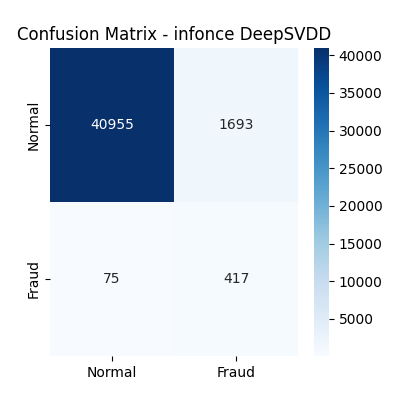

ROC Curve:


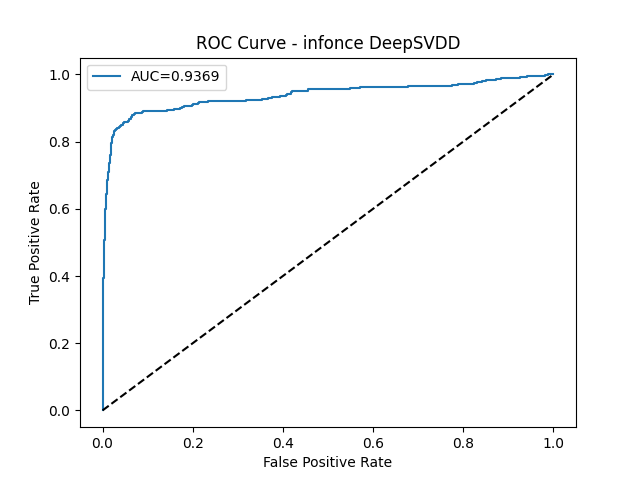

Precision-Recall Curve:


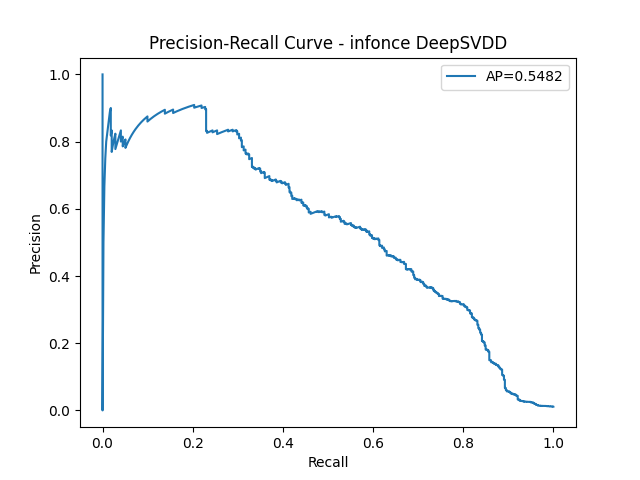


=== INFONCE - DeepSVDD ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.20      0.85      0.32       492

    accuracy                           0.96     43140
   macro avg       0.60      0.90      0.65     43140
weighted avg       0.99      0.96      0.97     43140

Confusion Matrix:


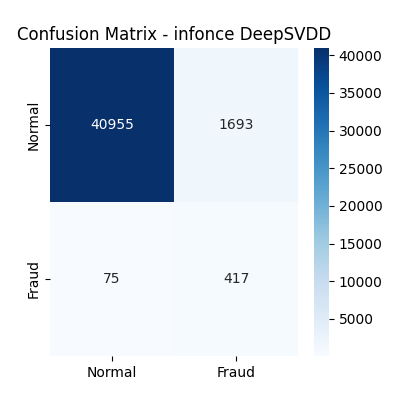

ROC Curve:


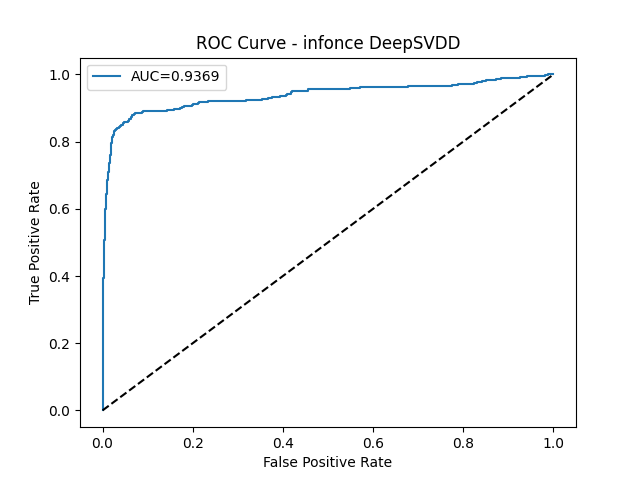

Precision-Recall Curve:


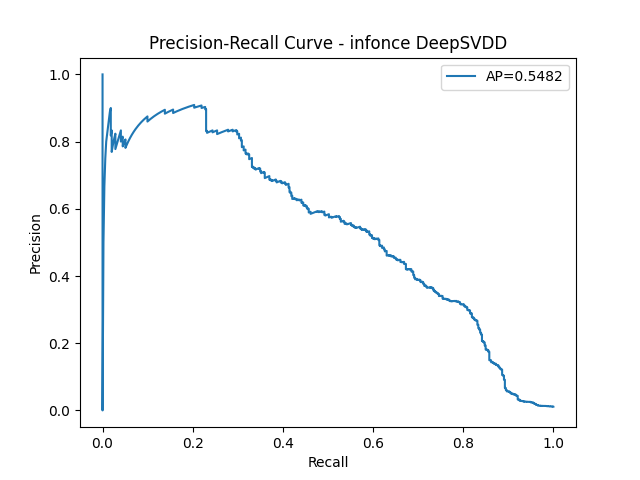


=== INFONCE - Autoencoder ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.19      0.84      0.31       492

    accuracy                           0.96     43140
   macro avg       0.59      0.90      0.64     43140
weighted avg       0.99      0.96      0.97     43140

Confusion Matrix:


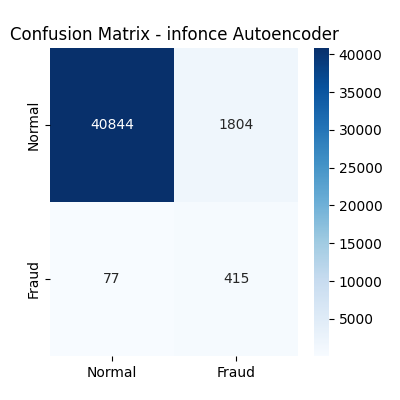

ROC Curve:


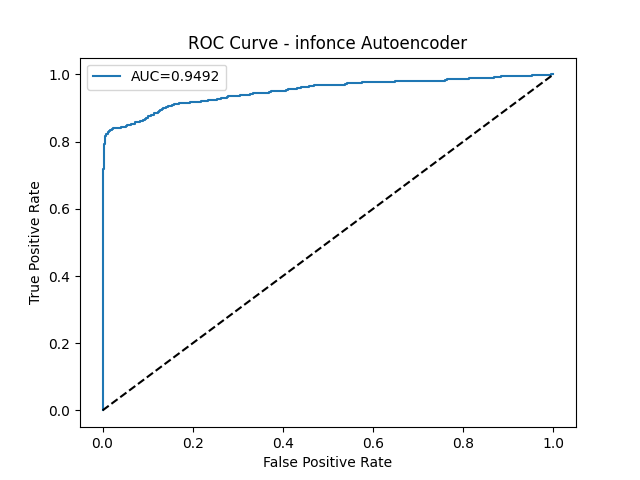

Precision-Recall Curve:


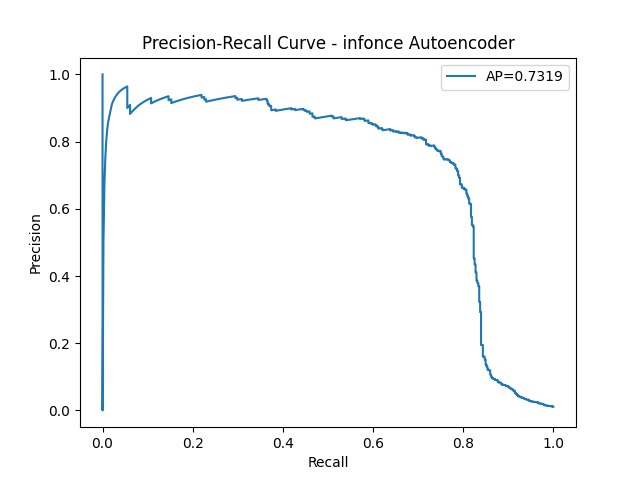


=== INFONCE - IsolationForest ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.19      0.86      0.32       492

    accuracy                           0.96     43140
   macro avg       0.60      0.91      0.65     43140
weighted avg       0.99      0.96      0.97     43140

Confusion Matrix:


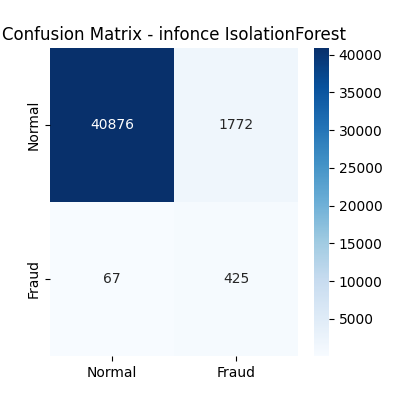

ROC Curve:


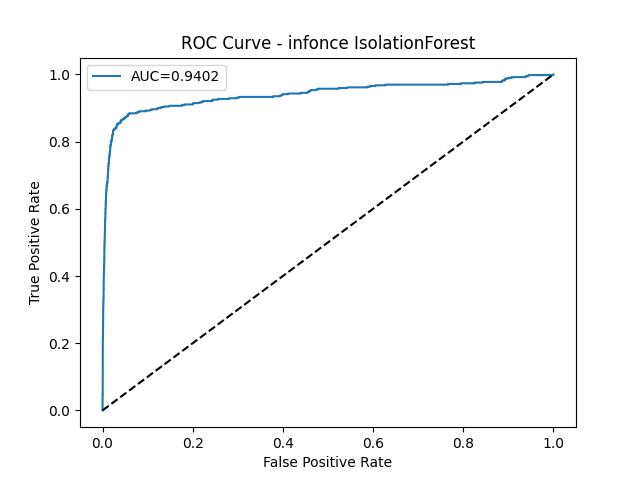

Precision-Recall Curve:


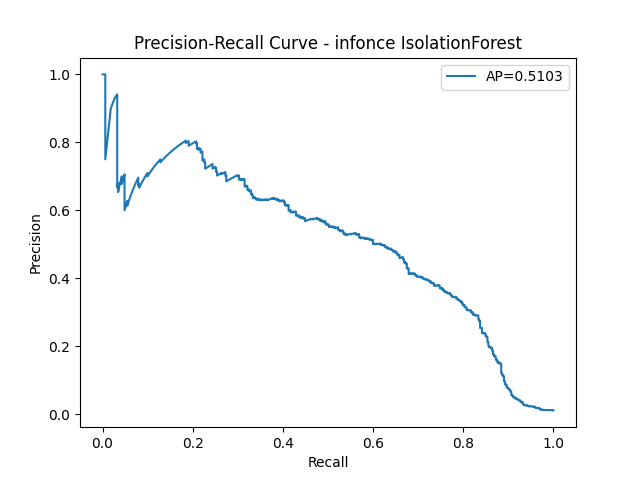


=== BARLOW - DeepSVDD ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.18      0.83      0.30       492

    accuracy                           0.96     43140
   macro avg       0.59      0.89      0.64     43140
weighted avg       0.99      0.96      0.97     43140

Confusion Matrix:


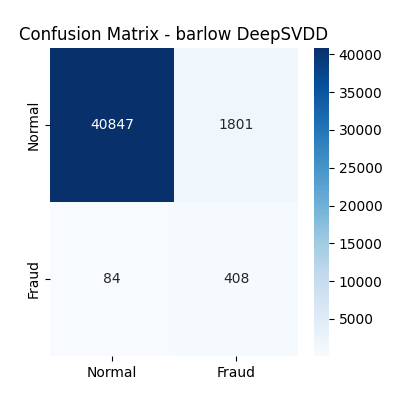

ROC Curve:


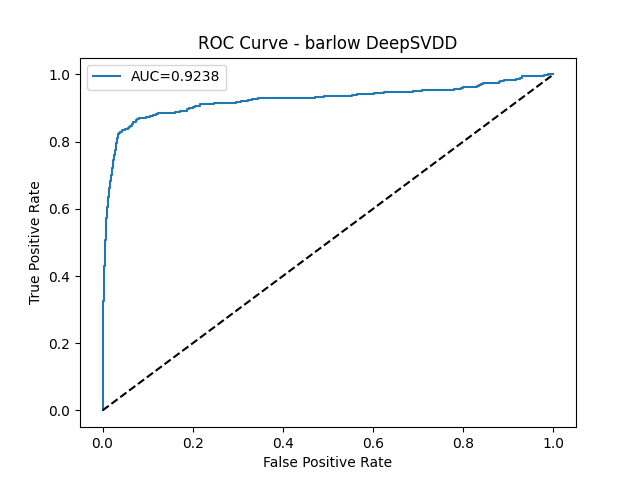

Precision-Recall Curve:


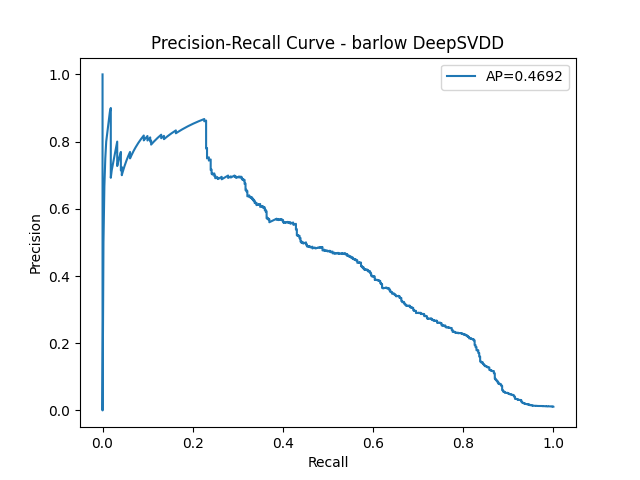


=== BARLOW - Autoencoder ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.18      0.85      0.30       492

    accuracy                           0.95     43140
   macro avg       0.59      0.90      0.64     43140
weighted avg       0.99      0.95      0.97     43140

Confusion Matrix:


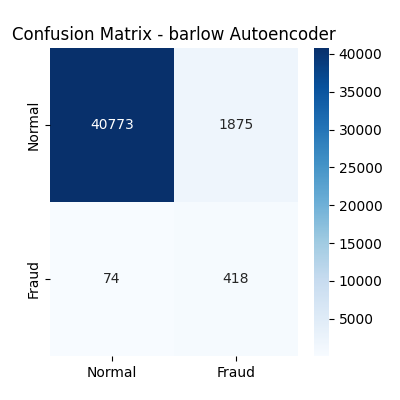

ROC Curve:


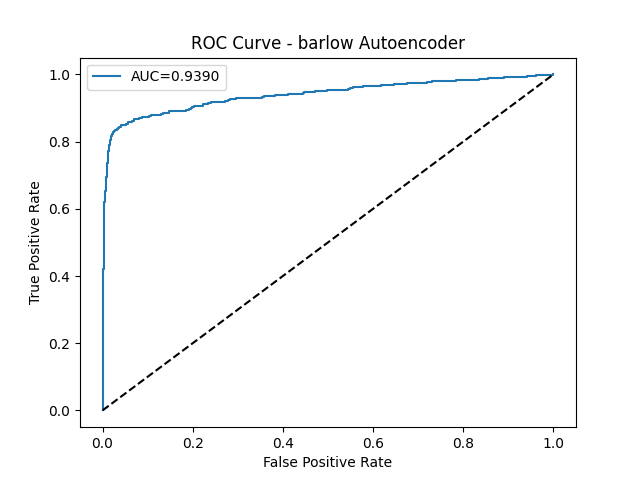

Precision-Recall Curve:


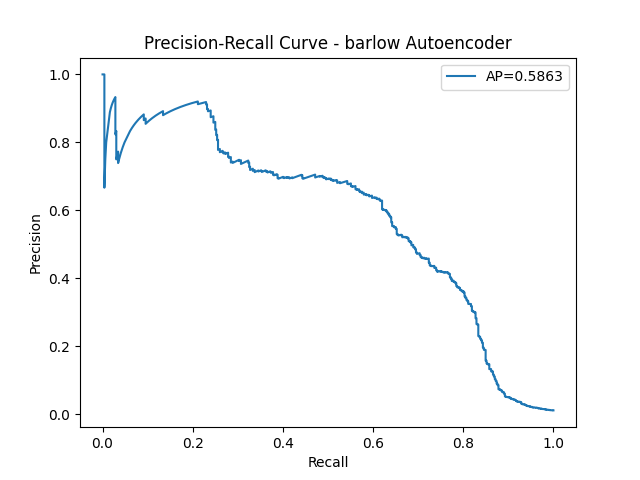


=== BARLOW - IsolationForest ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.18      0.86      0.30       492

    accuracy                           0.95     43140
   macro avg       0.59      0.91      0.64     43140
weighted avg       0.99      0.95      0.97     43140

Confusion Matrix:


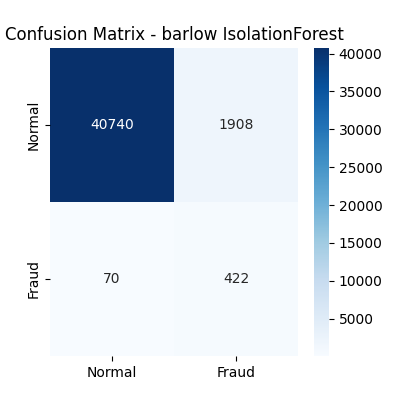

ROC Curve:


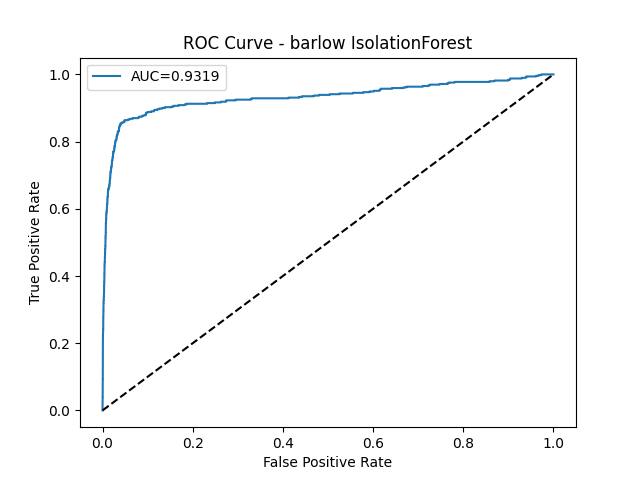

Precision-Recall Curve:


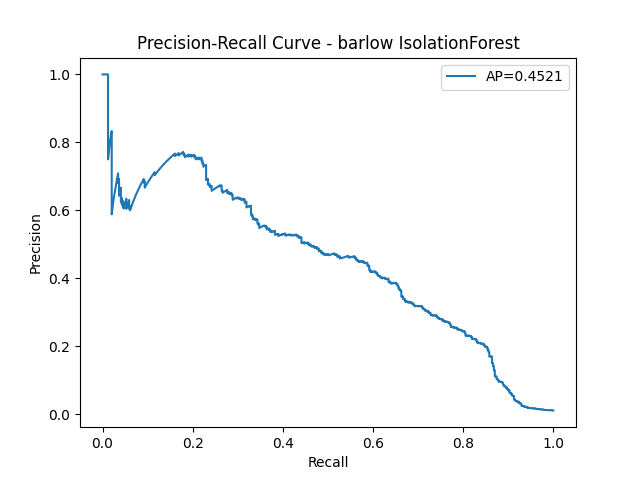


=== VICREG - DeepSVDD ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.19      0.84      0.30       492

    accuracy                           0.96     43140
   macro avg       0.59      0.90      0.64     43140
weighted avg       0.99      0.96      0.97     43140

Confusion Matrix:


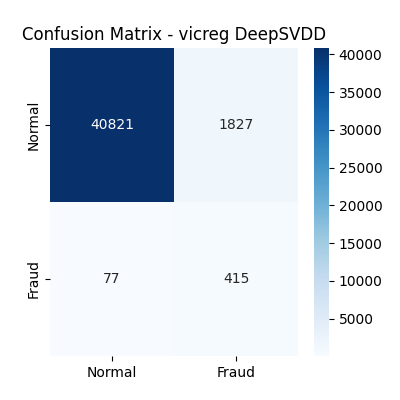

ROC Curve:


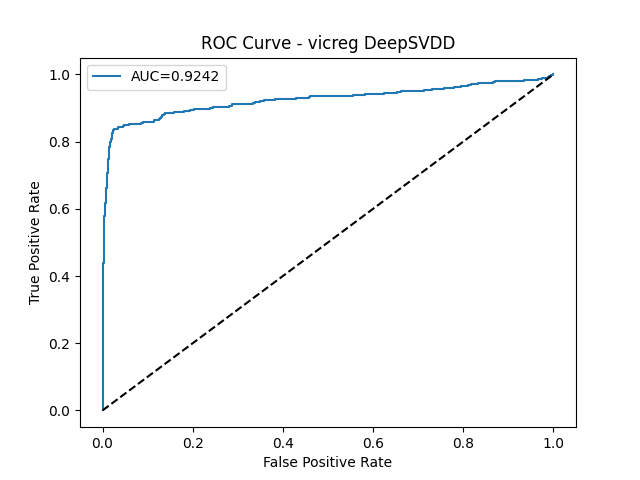

Precision-Recall Curve:


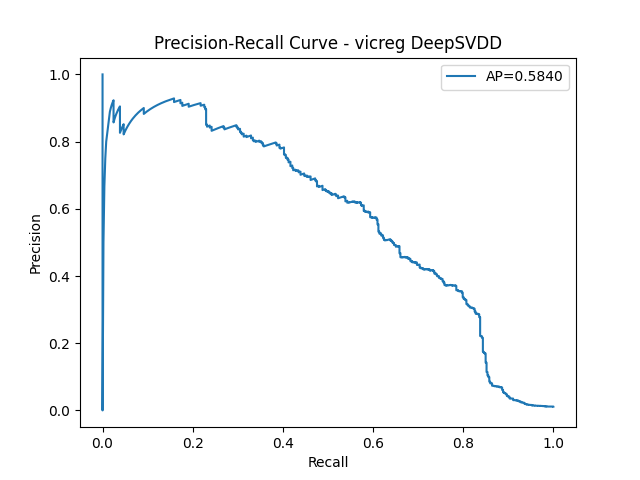


=== VICREG - Autoencoder ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.19      0.85      0.31       492

    accuracy                           0.96     43140
   macro avg       0.59      0.90      0.64     43140
weighted avg       0.99      0.96      0.97     43140

Confusion Matrix:


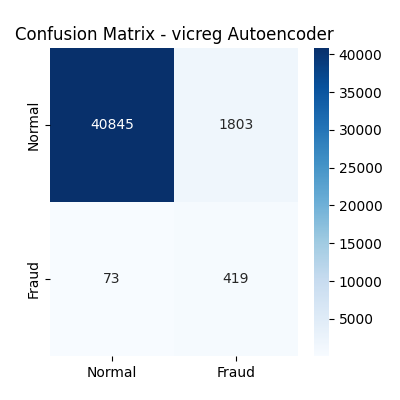

ROC Curve:


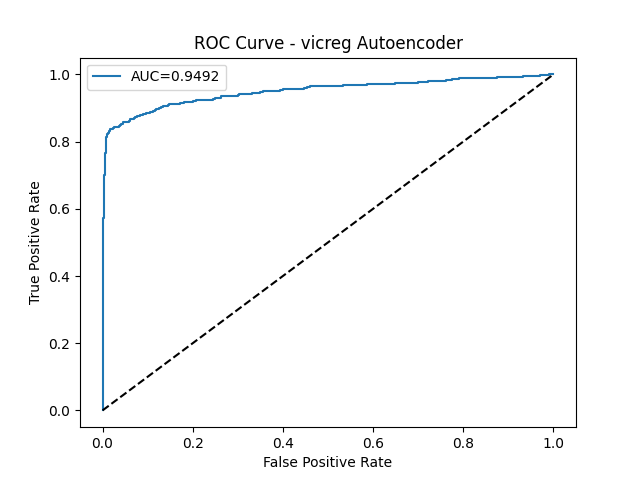

Precision-Recall Curve:


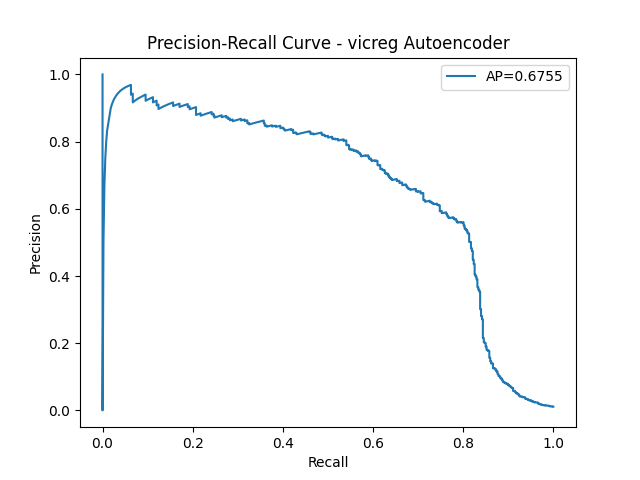


=== VICREG - IsolationForest ===
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     42648
       Fraud       0.19      0.87      0.31       492

    accuracy                           0.95     43140
   macro avg       0.59      0.91      0.64     43140
weighted avg       0.99      0.95      0.97     43140

Confusion Matrix:


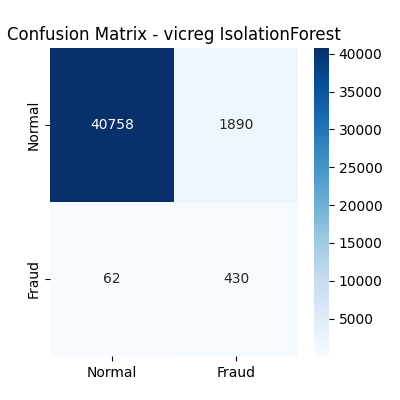

ROC Curve:


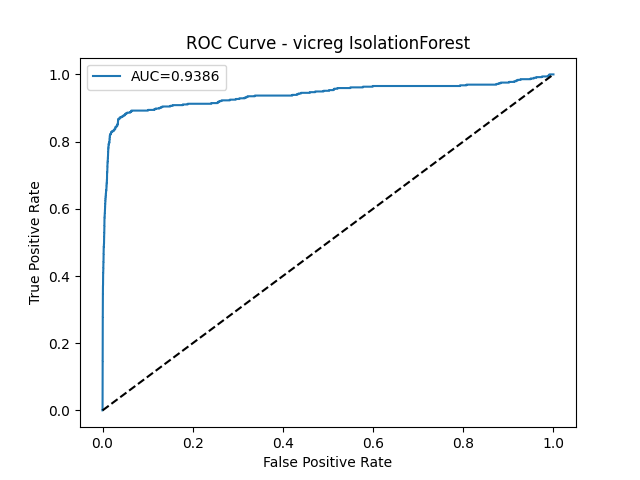

Precision-Recall Curve:


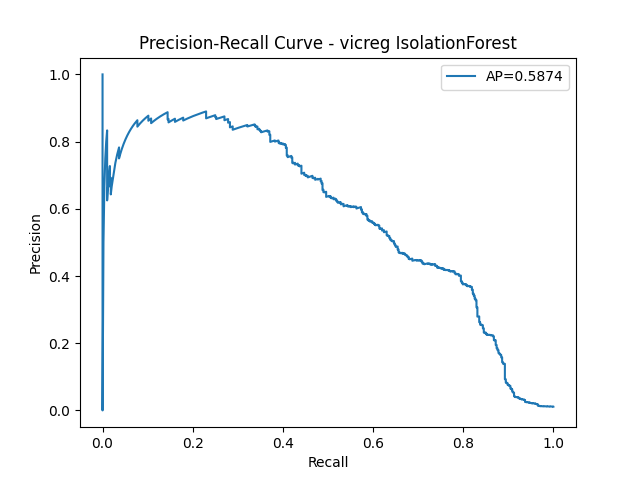

In [ ]:
import os
import pandas as pd
from IPython.display import Image, display

# Paths
EVAL_DIR = os.path.join(ARTIFACTS_DIR, "evaluation")
metrics_df = pd.read_csv(os.path.join(EVAL_DIR, "metrics_summary.csv"))

# Display metrics summary table first
print("📊 Metrics Summary:")
display(metrics_df)

# Loop through each combination
for _, row in metrics_df.iterrows():
    emb_type = row["embedding_type"]
    method = row["method"]

    combo_dir = os.path.join(EVAL_DIR, f"{emb_type}_{method}")
    report_path = os.path.join(combo_dir, "classification_report.txt")
    cm_path = os.path.join(combo_dir, "confusion_matrix.png")
    roc_path = os.path.join(combo_dir, "roc_curve.png")
    pr_path = os.path.join(combo_dir, "pr_curve.png")

    print(f"\n=== {emb_type.upper()} - {method} ===")

    # Classification report
    if os.path.exists(report_path):
        with open(report_path, "r") as f:
            print(f.read())

    # Confusion Matrix
    if os.path.exists(cm_path):
        print("Confusion Matrix:")
        display(Image(filename=cm_path))

    # ROC Curve
    if os.path.exists(roc_path):
        print("ROC Curve:")
        display(Image(filename=roc_path))

    # Precision-Recall Curve
    if os.path.exists(pr_path):
        print("Precision-Recall Curve:")
        display(Image(filename=pr_path))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

# Path to your Train_normal.csv
train_path = "/content/drive/MyDrive/credit_fraud_scarf/artifacts/preprocessing/Train_normal.csv"
scaling_save_path = "/content/drive/MyDrive/credit_fraud_scarf/artifacts/scaling_params.csv"

# Load Train_normal
train_df = pd.read_csv(train_path)

# Compute mean and std
scaling_stats = pd.DataFrame({
    "column": ["Time", "Amount"],
    "mean": [train_df["Time"].mean(), train_df["Amount"].mean()],
    "std": [train_df["Time"].std(), train_df["Amount"].std()]
})

# Save to Drive
scaling_stats.to_csv(scaling_save_path, index=False)
print(f"✅ Scaling parameters saved to: {scaling_save_path}")

✅ Scaling parameters saved to: /content/drive/MyDrive/credit_fraud_scarf/artifacts/scaling_params.csv
